<a href="https://colab.research.google.com/github/caprolaliac/MLPrac/blob/main/genre%20prediction%20and%20style%20transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install librosa -q
!pip install numpy pandas scikit-learn -q
!pip install tensorflow keras -q
!pip install matplotlib -q
!pip install pydub -q
!apt-get install -y ffmpeg

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler, minmax_scale
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Activation, LeakyReLU
from tensorflow.keras.layers import Concatenate, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


In [ ]:
input_dir = '/content/drive/MyDrive/GTZAN/Data/genres_original'
csv_file_30s = '/content/drive/MyDrive/GTZAN/Data/features_30_sec.csv'
csv_file_3s = '/content/drive/MyDrive/GTZAN/Data/features_3_sec.csv'
image_dir = '/content/drive/MyDrive/GTZAN/Data/images_original'

In [ ]:
df_30s = pd.read_csv(csv_file_30s)
df_3s = pd.read_csv(csv_file_3s)

In [ ]:
df_30s.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


In [ ]:
df_3s.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


In [ ]:
df_30s = df_30s.drop('filename', axis = 1)
df_3s = df_3s.drop('filename', axis = 1)

In [ ]:
data = df_30s.iloc[0:, 1:]
y = data['label']
X = data.loc[:, data.columns != 'label']

In [ ]:
cols = X.columns
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)
X = pd.DataFrame(np_scaled, columns = cols)

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

# concatenate with target label
finalDf = pd.concat([principalDf, y], axis = 1)

pca.explained_variance_ratio_


array([0.24644968, 0.22028192])

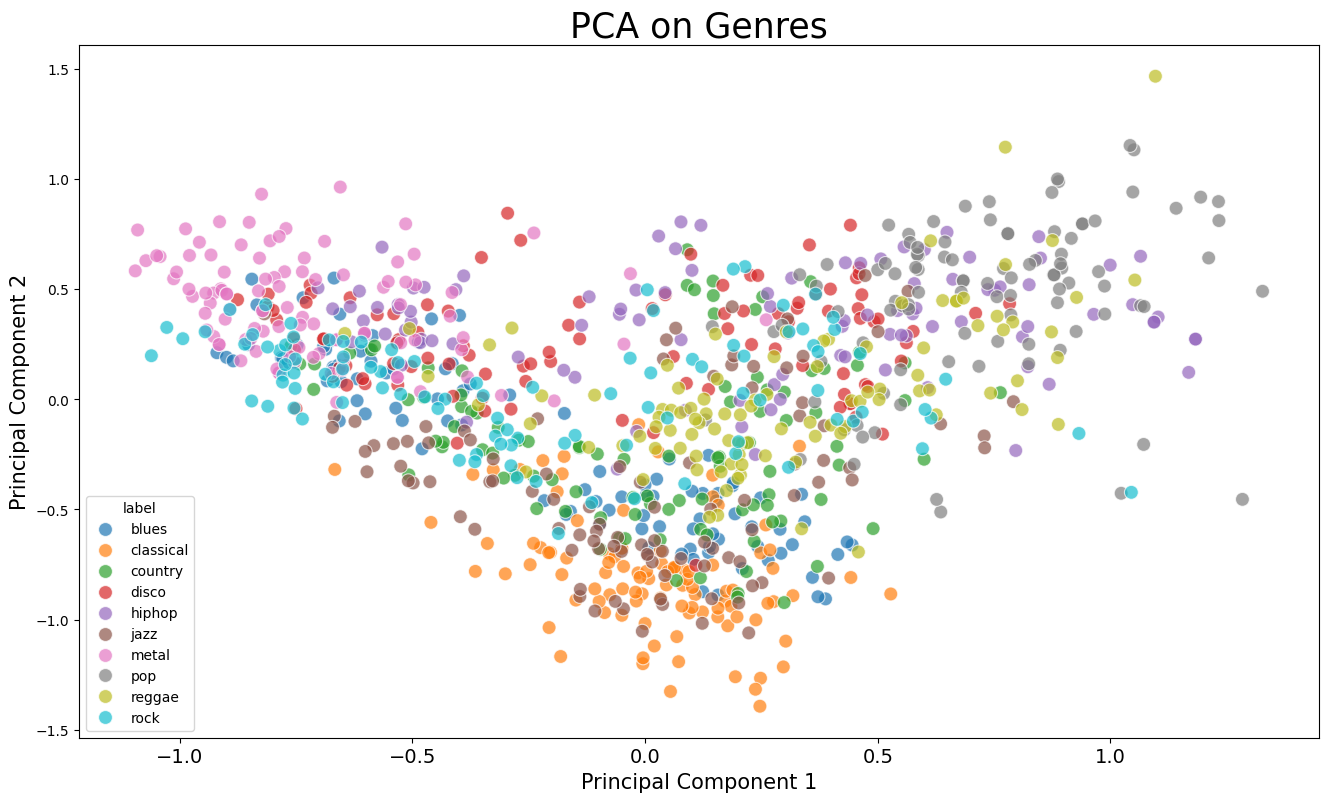

In [ ]:
plt.figure(figsize = (16, 9))
sns.scatterplot(x = "principal component 1", y = "principal component 2", data = finalDf, hue = "label", alpha = 0.7,
               s = 100);

plt.title('PCA on Genres', fontsize = 25)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10);
plt.xlabel("Principal Component 1", fontsize = 15)
plt.ylabel("Principal Component 2", fontsize = 15)
plt.savefig("PCA Scattert.jpg")

In [ ]:
finalDf

,principal component 1,principal component 2,label
0,-0.394212,-0.116145,blues
1,0.052019,-0.270757,blues
2,-0.479184,-0.224616,blues
3,0.017145,-0.439886,blues
4,-0.160395,-0.508617,blues
...,...,...,...
995,-0.754452,-0.039476,rock
996,-0.810739,-0.031233,rock
997,-0.845324,-0.007202,rock
998,-0.234262,-0.372666,rock


In [ ]:
X = df_30s.iloc[:,:-1]
y = df_30s.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2,
                                                    random_state = 42)

In [ ]:
labelencoder = LabelEncoder()
y_train = labelencoder.fit_transform(y_train)
y_test = labelencoder.transform(y_test)
len(labelencoder.classes_)

10

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train.shape

(800, 58)

In [ ]:
def plot_history(hist):

    plt.figure(figsize=(20,15))
    fig, axs = plt.subplots(2)

    axs[0].plot(hist.history["accuracy"], label="train accuracy")
    axs[0].plot(hist.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")
    axs[1].plot(hist.history["loss"], label="train error")
    axs[1].plot(hist.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()

In [ ]:
model = Sequential()
model.add(Dense(units=256, activation='relu', input_dim=X_train.shape[1]))
model.add(Dropout(0.2))
model.add(Dense(units=256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=len(np.unique(y_train)), activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               15104     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 256)               6

In [ ]:
adam = optimizers.Adam(learning_rate=1e-5)
model.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, epochs=3000, batch_size=32,verbose=2,
                    validation_data=(X_test, y_test))

Streaming output truncated to the last 5000 lines.
Epoch 501/3000
25/25 - 0s - loss: 0.3373 - accuracy: 0.8850 - val_loss: 0.9110 - val_accuracy: 0.7250 - 168ms/epoch - 7ms/step
Epoch 502/3000
25/25 - 0s - loss: 0.3424 - accuracy: 0.8925 - val_loss: 0.9114 - val_accuracy: 0.7200 - 168ms/epoch - 7ms/step
Epoch 503/3000
25/25 - 0s - loss: 0.3130 - accuracy: 0.8938 - val_loss: 0.9122 - val_accuracy: 0.7200 - 181ms/epoch - 7ms/step
Epoch 504/3000
25/25 - 1s - loss: 0.3434 - accuracy: 0.8813 - val_loss: 0.9169 - val_accuracy: 0.7150 - 525ms/epoch - 21ms/step
Epoch 505/3000
25/25 - 0s - loss: 0.3128 - accuracy: 0.8788 - val_loss: 0.9160 - val_accuracy: 0.7150 - 252ms/epoch - 10ms/step
Epoch 506/3000
25/25 - 0s - loss: 0.3176 - accuracy: 0.8850 - val_loss: 0.9169 - val_accuracy: 0.7150 - 183ms/epoch - 7ms/step
Epoch 507/3000
25/25 - 0s - loss: 0.3082 - accuracy: 0.8913 - val_loss: 0.9153 - val_accuracy: 0.7150 - 160ms/epoch - 6ms/step
Epoch 508/3000
25/25 - 0s - loss: 0.3365 - accuracy: 0.876

Training accuracy: 0.9950000047683716
Test accuracy: 0.7549999952316284


<Figure size 2000x1500 with 0 Axes>

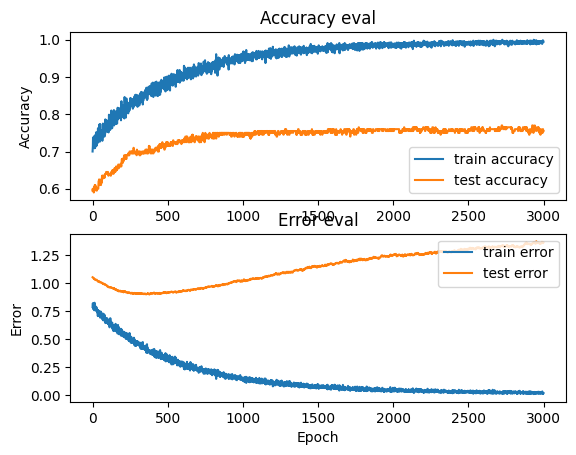

In [ ]:
train_accuracy = history.history['accuracy'][-1]  # Last epoch accuracy
test_accuracy = history.history['val_accuracy'][-1]  # Last epoch validation accuracy

print('Training accuracy:', train_accuracy)
print('Test accuracy:', test_accuracy)
plot_history(history)

In [ ]:
model_path = "/content/drive/MyDrive/GTZAN/model.h5"
model.save(model_path)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
print(f"Model saved to {model_path}")

Model saved to /content/drive/MyDrive/GTZAN/model.h5


In [ ]:
!pip install tensorflow-addons -q

In [ ]:
from tensorflow.keras import layers
import tensorflow_addons as tfa

In [ ]:
genre_model = tf.keras.models.load_model("/content/drive/MyDrive/GTZAN/model.h5")

In [ ]:
genre_model

In [ ]:
import librosa
import pandas as pd

def preprocess_audio(audio_file):
    y, sr = librosa.load(audio_file)

    # Extract features
    feature_names = ['chroma_stft_mean', 'chroma_stft_var', 'rms_mean', 'rms_var', 'spectral_centroid_mean', 'spectral_centroid_var', 'spectral_bandwidth_mean', 'spectral_bandwidth_var', 'rolloff_mean', 'rolloff_var', 'zero_crossing_rate_mean', 'zero_crossing_rate_var']
    features = []
    for feature_name in feature_names:
        feature = librosa.feature.spectral(y=y, sr=sr, n_mfcc=20, pad_mode='constant', **{feature_name: True})
        features.append(np.mean(feature))
        features.append(np.var(feature))

    mfcc_mean = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20), axis=1)
    mfcc_var = np.var(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20), axis=1)
    features.extend(mfcc_mean)
    features.extend(mfcc_var)

    # Normalize the features
    scaler = StandardScaler()
    features = scaler.fit_transform([features])

    return features

In [ ]:
def predict_genre(audio_file):
    #Pre-processing
    input_data = preprocess_audio(audio_file)
    #Prediction
    predictions = genre_model.predict(input_data)
    predicted_genre_idx = np.argmax(predictions)
    predicted_genre = labelencoder.classes_[predicted_genre_idx]

    return predicted_genre

**CYCLE GAN**

In [ ]:
!pip install git+https://github.com/tensorflow/examples.git -q
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

AUTOTUNE = tf.data.AUTOTUNE

  Preparing metadata (setup.py) ... done


In [ ]:
!pip install glob -q

ERROR: Could not find a version that satisfies the requirement glob (from versions: none)
ERROR: No matching distribution found for glob


In [ ]:
import tensorflow as tf
import os
import glob

def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)  # Assuming the images are PNG
    return image

def preprocess_image(image, size=(432, 288)):
    image = tf.image.resize(image, size)
    image = (image / 127.5) - 1.0  # Normalize to [-1, 1]
    return image

def load_and_preprocess_image(image_path, size=(432, 288)):
    return preprocess_image(load_image(image_path), size)

def create_dataset(image_dir, size=(432, 288)):
    image_paths = glob.glob(os.path.join(image_dir, '**/*.png'), recursive=True)
    dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    dataset = dataset.map(lambda x: load_and_preprocess_image(x, size), num_parallel_calls=tf.data.AUTOTUNE)
    return dataset


genre1_dir = '/content/drive/MyDrive/GTZAN/Data/images_original/blues'
genre2_dir = '/content/drive/MyDrive/GTZAN/Data/images_original/jazz'
# can add more genres...
dataset_genre1 = create_dataset(genre1_dir)
dataset_genre2 = create_dataset(genre2_dir)

# Prepare dataset
BATCH_SIZE = 1
def prepare_dataset(dataset):
    dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

train_genre1 = prepare_dataset(dataset_genre1)
train_genre2 = prepare_dataset(dataset_genre2)
test_genre1 = prepare_dataset(dataset_genre1)
test_genre2 = prepare_dataset(dataset_genre2)


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

def residual_block(x, filters):
    res = x
    x = layers.Conv2D(filters, kernel_size=3, strides=1, padding='same')(x)
    x = tfa.layers.InstanceNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, kernel_size=3, strides=1, padding='same')(x)
    x = tfa.layers.InstanceNormalization()(x)
    x = layers.add([x, res])
    return x

def build_generator(input_shape, num_res_blocks=6):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, kernel_size=7, strides=1, padding='same')(inputs)
    x = tfa.layers.InstanceNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(128, kernel_size=3, strides=2, padding='same')(x)
    x = tfa.layers.InstanceNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(256, kernel_size=3, strides=2, padding='same')(x)
    x = tfa.layers.InstanceNormalization()(x)
    x = layers.ReLU()(x)

    for _ in range(num_res_blocks):
        x = residual_block(x, 256)

    x = layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding='same')(x)
    x = tfa.layers.InstanceNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding='same')(x)
    x = tfa.layers.InstanceNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(3, kernel_size=7, strides=1, padding='same')(x)
    x = layers.Activation('tanh')(x)

    return tf.keras.Model(inputs, x)

def build_discriminator(input_shape):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, kernel_size=4, strides=2, padding='same')(inputs)
    x = layers.LeakyReLU(alpha=0.2)(x)

    x = layers.Conv2D(128, kernel_size=4, strides=2, padding='same')(x)
    x = tfa.layers.InstanceNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    x = layers.Conv2D(256, kernel_size=4, strides=2, padding='same')(x)
    x = tfa.layers.InstanceNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    x = layers.Conv2D(512, kernel_size=4, strides=2, padding='same')(x)
    x = tfa.layers.InstanceNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    x = layers.Conv2D(1, kernel_size=4, strides=1, padding='same')(x)

    return tf.keras.Model(inputs, x)

# Example usage
input_shape = (432, 288, 3)  # Adjust based on your image size
G_A2B = build_generator(input_shape, num_res_blocks=6)
G_B2A = build_generator(input_shape, num_res_blocks=6)
D_A = build_discriminator(input_shape)
D_B = build_discriminator(input_shape)


In [ ]:
import tensorflow as tf

# Loss functions
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    return real_loss + generated_loss

def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

# Optimizers
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# Training step
@tf.function
def train_step(real_x, real_y):
    with tf.GradientTape(persistent=True) as tape:
        fake_y = G_A2B(real_x, training=True)
        cycled_x = G_B2A(fake_y, training=True)

        fake_x = G_B2A(real_y, training=True)
        cycled_y = G_A2B(fake_x, training=True)

        same_x = G_B2A(real_x, training=True)
        same_y = G_A2B(real_y, training=True)

        disc_real_x = D_A(real_x, training=True)
        disc_real_y = D_B(real_y, training=True)

        disc_fake_x = D_A(fake_x, training=True)
        disc_fake_y = D_B(fake_y, training=True)

        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)

        total_cycle_loss = tf.reduce_mean(tf.abs(real_x - cycled_x)) + tf.reduce_mean(tf.abs(real_y - cycled_y))

        total_gen_g_loss = gen_g_loss + total_cycle_loss * 10.0
        total_gen_f_loss = gen_f_loss + total_cycle_loss * 10.0

        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

    generator_g_gradients = tape.gradient(total_gen_g_loss, G_A2B.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, G_B2A.trainable_variables)

    discriminator_x_gradients = tape.gradient(disc_x_loss, D_A.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, D_B.trainable_variables)

    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, G_A2B.trainable_variables))
    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, G_B2A.trainable_variables))

    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients, D_A.trainable_variables))
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients, D_B.trainable_variables))

# Training loop
EPOCHS = 200

for epoch in range(EPOCHS):
    for image_x, image_y in tf.data.Dataset.zip((train_genre1, train_genre2)):
        train_step(image_x, image_y)

    print(f'Epoch {epoch + 1}/{EPOCHS} completed.')

# Save models
G_A2B.save('G_A2B.h5')
G_B2A.save('G_B2A.h5')
D_A.save('D_A.h5')
D_B.save('D_B.h5')

Epoch 1/200 completed.
